In [2]:
import pandas_datareader as pdr 

In [3]:
df=pdr.get_data_tiingo('AAPL',api_key=key)

In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df=pd.read_csv("AAPL.csv")

In [7]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-06-14 00:00:00+00:00,130.48,130.54,127.070,127.82,96906490,130.48,130.54,127.070,127.82,96906490,0.0,1.0
1253,AAPL,2021-06-15 00:00:00+00:00,129.64,130.60,129.390,129.94,62746332,129.64,130.60,129.390,129.94,62746332,0.0,1.0
1254,AAPL,2021-06-16 00:00:00+00:00,130.15,130.89,128.461,130.37,91339351,130.15,130.89,128.461,130.37,91339351,0.0,1.0
1255,AAPL,2021-06-17 00:00:00+00:00,131.79,132.55,129.650,129.80,96721669,131.79,132.55,129.650,129.80,96721669,0.0,1.0
1256,AAPL,2021-06-18 00:00:00+00:00,130.46,131.51,130.240,130.71,108953309,130.46,131.51,130.240,130.71,108953309,0.0,1.0


In [8]:
# we are taking only close coloumn for our analysis,same is applicable for all coloumns
df2=df.reset_index()['close']

In [9]:
df2.shape

(1257,)

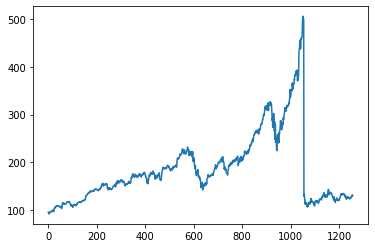

In [10]:
import matplotlib.pyplot as plt
plt.plot(df2)

LSTM is very sensitive to the scale of the data so we have to preprocess the data and do featurescaling

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [12]:
df2

array([[0.00847724],
       [0.00980558],
       [0.00328463],
       ...,
       [0.09204202],
       [0.0960029 ],
       [0.09279073]])

Doing train test split,and we will not use cross validation or random seed as the next data is dependent on the previous one,so the data points should be sequenced as per date for sequential data poinnts

In [13]:
train_size=int(len(df2)*0.65)
test_size=len(df2)-train_size
train_data,test_data=df2[0:train_size,:],df2[train_size:len(df2),:]

In [14]:
test_size,train_size

(440, 817)

Converting whole dataset into features and lebels depending on time steps,that on how many data points our next datapoint should be dependemt on.if we take timesteps =3 then our 4th datapoint is dependent on 1st 2nd and 3rd datapoints.so number of features are=no. of time steps.

In [15]:
#creating training and testing dataset
import numpy
def create_dataste(dataset,time_step=1):
    datax,datay=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        datax.append(a)
        datay.append(dataset[i+time_step,0])
    return numpy.array(datax),numpy.array(datay)

In [16]:
time_step=100
x_train,y_train=create_dataste(train_data,time_step)
x_test,y_test=create_dataste(test_data,time_step)

To apply stacked LSTM model we weed always our dataset into 3 dimension

In [17]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)


Creating stacked LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()
#here input shape is equal to our time step
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
#stacked lstm=one lstm after another
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 14s 513ms/step - loss: 0.0101 - val_loss: 0.0445
Epoch 2/100
12/12 [==============================] - 4s 317ms/step - loss: 0.0021 - val_loss: 0.0275
Epoch 3/100
12/12 [==============================] - 4s 321ms/step - loss: 0.0011 - val_loss: 0.0231
Epoch 4/100
12/12 [==============================] - 4s 322ms/step - loss: 7.0418e-04 - val_loss: 0.0209
Epoch 5/100
12/12 [==============================] - 4s 321ms/step - loss: 4.9377e-04 - val_loss: 0.0214
Epoch 6/100
12/12 [==============================] - 4s 318ms/step - loss: 4.6720e-04 - val_loss: 0.0206
Epoch 7/100
12/12 [==============================] - 4s 304ms/step - loss: 4.2444e-04 - val_loss: 0.0195
Epoch 8/100
12/12 [==============================] - 4s 293ms/step - loss: 4.1551e-04 - val_loss: 0.0190
Epoch 9/100
12/12 [==============================] - 4s 316ms/step - loss: 3.9994e-04 - val_loss: 0.0186
Epoch 10/100
12/12 [==============================] - 4s 304ms/ste

In [22]:
#taking prediction from our model
train_pred=model.predict(x_train)
test_pred=model.predict(x_test)

In [23]:
#transform back to original scale of data by inverse scaling
train_pred=scaler.inverse_transform(train_pred)
test_pred=scaler.inverse_transform(test_pred)

In [24]:
import math
from sklearn.metrics import mean_squared_error
# train data rmse
math.sqrt(mean_squared_error(y_train,train_pred))

178.15939017339508

In [25]:
# test data rmse
math.sqrt(mean_squared_error(y_test,test_pred))
# as both test and train rmse is almost same so our model is good enough :)

240.99172793830837

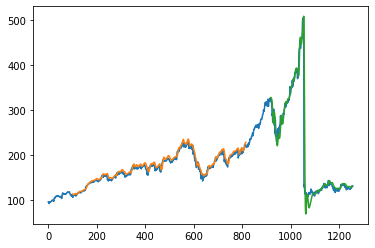

In [26]:
#ploting
#shift train predictions for plotting
look_back=100
train_pred_plot=numpy.empty_like(df2)
train_pred_plot[:,:]=np.nan
train_pred_plot[look_back:look_back+len(train_pred),:]=train_pred
#shift test prediction for plotting
test_pred_plot=numpy.empty_like(df2)
test_pred_plot[:,:]=np.nan
test_pred_plot[len(train_pred)+2*look_back+1:len(df2)-1,:]=test_pred
#plotting baseline and predictions
plt.plot(scaler.inverse_transform(df2))#baseline
plt.plot(train_pred_plot)#predictions of train data
plt.plot(test_pred_plot)#predictions on test data
plt.show()

In [27]:
len(test_data)

440

In [56]:
#for predicting the price for the next day it is not present in the dataset
x_input=test_data[340:].reshape(1,-1) 
x_input.shape

(1, 100)

In [57]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [58]:
#logic for predicting next 100 days prics
from numpy import array


lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.09812135]
101
1 day input [0.10880328 0.09641348 0.10167854 0.10373143 0.10119551 0.10952783
 0.10800628 0.10836855 0.1061949  0.1046975  0.10406956 0.1046492
 0.09938413 0.09370849 0.09097935 0.09136578 0.08201908 0.08168096
 0.08044922 0.06991909 0.07057119 0.08634223 0.07989373 0.07250332
 0.06784205 0.07095761 0.05873687 0.07014853 0.06747977 0.0722618
 0.0700157  0.07716459 0.08098056 0.07902427 0.06880811 0.06750392
 0.07571549 0.0736626  0.06774544 0.06895302 0.07045043 0.07088516
 0.06728656 0.07272069 0.07477358 0.08177756 0.08252626 0.0866079
 0.09254921 0.09891317 0.09467456 0.10237894 0.09658254 0.102548
 0.10172684 0.10336916 0.09919092 0.10013283 0.09636517 0.10211327
 0.10307934 0.10228233 0.10032605 0.10008453 0.09520589 0.09781427
 0.08648714 0.08709093 0.09105181 0.09218693 0.08407197 0.08180171
 0.07421809 0.07953146 0.08552107 0.08267117 0.07924164 0.07885521
 0.08518295 0.08064243 0.08467576 0.08419273 0.08407197 0.08028016
 0.078662   0.07786499 0.07974882 0.07

8 day output [[0.11140873]]
9 day input [0.1061949  0.1046975  0.10406956 0.1046492  0.09938413 0.09370849
 0.09097935 0.09136578 0.08201908 0.08168096 0.08044922 0.06991909
 0.07057119 0.08634223 0.07989373 0.07250332 0.06784205 0.07095761
 0.05873687 0.07014853 0.06747977 0.0722618  0.0700157  0.07716459
 0.08098056 0.07902427 0.06880811 0.06750392 0.07571549 0.0736626
 0.06774544 0.06895302 0.07045043 0.07088516 0.06728656 0.07272069
 0.07477358 0.08177756 0.08252626 0.0866079  0.09254921 0.09891317
 0.09467456 0.10237894 0.09658254 0.102548   0.10172684 0.10336916
 0.09919092 0.10013283 0.09636517 0.10211327 0.10307934 0.10228233
 0.10032605 0.10008453 0.09520589 0.09781427 0.08648714 0.08709093
 0.09105181 0.09218693 0.08407197 0.08180171 0.07421809 0.07953146
 0.08552107 0.08267117 0.07924164 0.07885521 0.08518295 0.08064243
 0.08467576 0.08419273 0.08407197 0.08028016 0.078662   0.07786499
 0.07974882 0.07607777 0.08175341 0.08177756 0.0838063  0.08474822
 0.08228475 0.08527956 

17 day output [[0.12743025]]
18 day input [0.08168096 0.08044922 0.06991909 0.07057119 0.08634223 0.07989373
 0.07250332 0.06784205 0.07095761 0.05873687 0.07014853 0.06747977
 0.0722618  0.0700157  0.07716459 0.08098056 0.07902427 0.06880811
 0.06750392 0.07571549 0.0736626  0.06774544 0.06895302 0.07045043
 0.07088516 0.06728656 0.07272069 0.07477358 0.08177756 0.08252626
 0.0866079  0.09254921 0.09891317 0.09467456 0.10237894 0.09658254
 0.102548   0.10172684 0.10336916 0.09919092 0.10013283 0.09636517
 0.10211327 0.10307934 0.10228233 0.10032605 0.10008453 0.09520589
 0.09781427 0.08648714 0.08709093 0.09105181 0.09218693 0.08407197
 0.08180171 0.07421809 0.07953146 0.08552107 0.08267117 0.07924164
 0.07885521 0.08518295 0.08064243 0.08467576 0.08419273 0.08407197
 0.08028016 0.078662   0.07786499 0.07974882 0.07607777 0.08175341
 0.08177756 0.0838063  0.08474822 0.08228475 0.08527956 0.09283903
 0.09081029 0.09204202 0.0960029  0.09279073 0.09812135 0.09974217
 0.10136007 0.102998

25 day output [[0.14347452]]
26 day input [0.07095761 0.05873687 0.07014853 0.06747977 0.0722618  0.0700157
 0.07716459 0.08098056 0.07902427 0.06880811 0.06750392 0.07571549
 0.0736626  0.06774544 0.06895302 0.07045043 0.07088516 0.06728656
 0.07272069 0.07477358 0.08177756 0.08252626 0.0866079  0.09254921
 0.09891317 0.09467456 0.10237894 0.09658254 0.102548   0.10172684
 0.10336916 0.09919092 0.10013283 0.09636517 0.10211327 0.10307934
 0.10228233 0.10032605 0.10008453 0.09520589 0.09781427 0.08648714
 0.08709093 0.09105181 0.09218693 0.08407197 0.08180171 0.07421809
 0.07953146 0.08552107 0.08267117 0.07924164 0.07885521 0.08518295
 0.08064243 0.08467576 0.08419273 0.08407197 0.08028016 0.078662
 0.07786499 0.07974882 0.07607777 0.08175341 0.08177756 0.0838063
 0.08474822 0.08228475 0.08527956 0.09283903 0.09081029 0.09204202
 0.0960029  0.09279073 0.09812135 0.09974217 0.10136007 0.10299865
 0.10465948 0.10633596 0.10802146 0.10971243 0.11140873 0.11311273
 0.11482812 0.11655896 0

Plotting the data

In [59]:
#for x-axis
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [60]:
import matplotlib.pyplot as plt

In [61]:
len(df2)

1257

In [62]:
df3=df2.tolist()
df3.extend(lst_output)

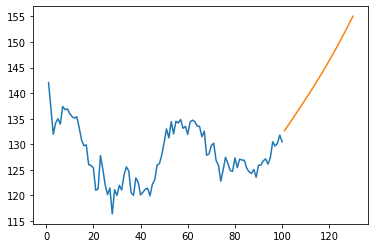

In [64]:
plt.plot(day_new,scaler.inverse_transform(df2[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.show()

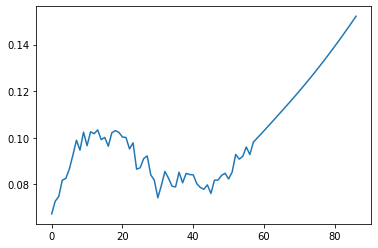

In [68]:
plt.plot(df3[1200:])